## 1. Task

We have to solve a machine learning problem aimed at automating business processes. Let's build a model that will predict the total duration of a taxi trip in New York.

Imagine you order a taxi from one point in New York to another, and the end point does not necessarily have to be within the city. How much will you have to pay for it? It is known that the cost of a taxi in the USA is calculated on the basis of a fixed rate + tariff cost, the value of which depends on time and distance. Tariffs vary depending on the city.

In turn, the travel time depends on many factors such as where you are coming from and where you are going, what time of day you make your trip, weather conditions, and so on.

Thus, if we develop an algorithm that can determine the duration of a trip, we can predict its cost in the most trivial way, for example, simply by multiplying the cost by a given fare.
Taxi services store huge amounts of information about trips, including data such as the final and starting point of the route, the date of the trip and its duration. This data can be used to predict the duration of a trip automatically using artificial intelligence.

**Business task:** determine the characteristics and use them to predict the duration of a taxi trip.

**Technical task:** build a machine learning model that, based on the proposed client characteristics, will predict a numerical attribute - taxi travel time. That is, solve the regression problem.

**Main goals of the project:**
1. Create a data set based on several sources of information
2. Design new features using Feature Engineering and identify the most significant ones when building a model
3. Explore the data provided and identify patterns
4. Build several models and select the best one according to a given metric
5. Design a process for predicting travel times for new data.

## 2. Introduction to data, basic analysis and data expansion

Let's start our research by getting acquainted with the data provided. We will also load additional data sources and expand our original dataset.

Let’s import in advance the modules that we will need to solve the problem:

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Let's read our source data file:

In [264]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


So, we have data on almost 1.5 million trips and 11 characteristics that describe each of the trips.

We will conditionally divide the characteristics of several groups. We will further pay separate attention to each of the groups.

**Data about the client and taxi fleet:**
* id - unique trip identifier
* vendor_id - unique identifier of the supplier (taxi fleet) associated with the trip record

**Time characteristics:**
* pickup_datetime - date and time when the trip counter was turned on
* dropoff_datetime - date and time when the counter was disabled

**Geographic information:**
* pickup_longitude - longitude at which the counter was turned on
* pickup_latitude - latitude at which the counter was turned on
* dropoff_longitude - longitude at which the counter was disabled
* dropoff_latitude - latitude at which the counter was disabled

**Other signs:**
* passenger_count - number of passengers in the vehicle (value entered by the driver)
* store_and_fwd_flag - a flag that indicates whether the trip record is stored in the vehicle's memory before being sent to the supplier. Y - store and forward, N - do not store or forward the trip.

**Target feature:**
* trip_duration - trip duration in seconds

_________________
First, let's look at the time frame in which we work with data.

Let's convert the pickup_datetime attribute into a datetime data type with the format year-month-day hour:minute:second (in the pd.to_datetime() function the parameter format='%Y-%m-%d %H:%M:%S').

Let us determine the time frame (excluding time) for which the data is presented.

In [265]:
taxi_data.pickup_datetime = pd.to_datetime(taxi_data.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
print('First trip: ', taxi_data.pickup_datetime.min(), '\n', 'Last trip: ', taxi_data.pickup_datetime.max())


First trip:  2016-01-01 00:00:17 
 Last trip:  2016-06-30 23:59:39


Data collected for the period from January 1 to June 30.

__________________
Let's look at the gaps.
How many missing values are there in the data (total across all columns of the table).

In [266]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no gaps in the data.

___________________________
Let's look at the statistical characteristics of some features.

a) How many unique taxi companies are present in the data?

b) What is the maximum number of passengers?

c) What is the average and median trip duration? Give your answer in seconds and round to the nearest whole number.

d) What is the minimum and maximum travel time (in seconds)?

In [267]:
print('Number of unique taxi fleets: ',taxi_data.vendor_id.nunique()) # number of unique taxi fleets
print('Max count of passangers: ', taxi_data.passenger_count.max(), 'passangers') # Max count of passangers
print('Average time of trip:', round(taxi_data.trip_duration.mean()), 'sec') # Average time of trip
print('Median time of trip:', round(taxi_data.trip_duration.median()), 'sec') # Median time of trip
print('Minimum time of trip:', round(taxi_data.trip_duration.min()), 'sec') # Minimum time of trip
print('Maximum time of trip:', round(taxi_data.trip_duration.max()), 'sec') # Maximum time of trip
taxi_data.describe()

Number of unique taxi fleets:  2
Max count of passangers:  9 passangers
Average time of trip: 959 sec
Median time of trip: 662 sec
Minimum time of trip: 1 sec
Maximum time of trip: 3526282 sec


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


__________________
The **add_datetime_features()** function takes as input a table with travel data (DataFrame) and returns the same table with 3 columns added to it:
* pickup_date - the date the counter was turned on - the start of the trip (without time);
* pickup_hour - hour of day when the meter is turned on;
* pickup_day_of_week - serial number of the day of the week (date) in which the counter was included.

a) How many trips were made on Saturday?

b) How many trips are made per day on average?

In [268]:
def add_datetime_features(df):
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.date
    df['pickup_hour'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.hour
    df['pickup_day_of_week'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.weekday
    return df

taxi_data = add_datetime_features(taxi_data)
print('Count of trips by day of week: \n', taxi_data['pickup_day_of_week'].value_counts()) # Count of trips by day of week
print('Average count of trip at day: \n', round((taxi_data.shape[0])/(taxi_data['pickup_date'].nunique()))) #Average count of trip at day

Count of trips by day of week: 
 4    223533
5    220868
3    218574
2    210136
1    202749
6    195366
0    187418
Name: pickup_day_of_week, dtype: int64
Average count of trip at day: 
 8015


____________
The **add_holiday_features()** function, which takes two tables as input:
* table with trip data;
* table with data on holidays;

and returns an updated table with trip data with the pickup_holiday column added to it - a binary indicator of whether the trip started on a holiday or not (1 - yes, 0 - no).

What is the median duration of a taxi trip on holidays?

In [269]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'])
def add_holiday_features(data, data_2, features='pickup_date', features_2='date', name='pickup_holiday'):
    features_2_list = []
    for i in range(len(data_2[features_2])):
        features_2_list.append(data_2[features_2][i])
        
    data[name] = data[features].apply(lambda x: 1 if x in features_2_list else 0)
    return data 

taxi_data = add_holiday_features(taxi_data, holiday_data, 'pickup_date', 'date', 'pickup_holiday')
taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_29826/1276341313.py:8: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



585.0

The data has columns containing latitude and longitude information. A lot of useful information can be extracted from them.

For example, knowing the latitude and longitude of the starting and ending points of the route, we can use the OSRM API.
The problem is that since our data contains information on more than one million trips, loading data using the API and pre-processing it can take several hours, or even days on a weak Internet connection. Therefore, we will take a pre-prepared data download from the OSRM API for each trip from the training and test samples of our data set.

___________
The add_osrm_features() function, which takes two tables as input:
* table with trip data;
* table with data from OSRM;

and returns an updated trip data table with 3 columns added to it:
* total_distance;
* total_travel_time;
* number_of_steps.

In [270]:
osrm_data = pd.read_csv('osrm_data_train.csv')
def add_osrm_features(data, osrm_data):
    osrm_features = [
        'id', 'total_distance', 
        'total_travel_time', 'number_of_steps'
    ]
    df = data.merge(
        osrm_data[osrm_features],
        on='id', 
        how='left'
    )
    return df
taxi_data = add_osrm_features(taxi_data, osrm_data)

___________
The get_haversine_distance function for calculating distance using the haversine formula (in kilometers)
The get_angle_direction function to calculate the angle of direction of movement (in degrees)

In [271]:
def get_haversine_distance(lat1, lng1, lat2, lng2): # function for calculating distance using the haversine formula (in kilometers);
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # radius of the earth in kilometers
    EARTH_RADIUS = 6371 
    # calculate the shortest distance h using the Haversine formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2): # function to calculate the angle of direction of movement (in degrees)
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # calculate the direction angle alpha using the bearing angle formula
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

__________
The add_geographical_features() function takes as input a table with travel data and returns an updated table with 2 columns added to it:
* haversine_distance - Haversine distance between the point at which the counter was turned on and the point at which the counter was turned off;
* direction - direction of movement from the point at which the counter was turned on to the point at which the counter was turned off.

What is Haversine's median travel distance (in kilometers)?

In [272]:
def add_geographical_features(taxi_data):
    taxi_data['haversine_distance'] = get_haversine_distance(
        taxi_data['pickup_latitude'], 
        taxi_data['pickup_longitude'], 
        taxi_data['dropoff_latitude'], 
        taxi_data['dropoff_longitude'])
    taxi_data['direction'] = get_angle_direction(
        taxi_data['pickup_latitude'], 
        taxi_data['pickup_longitude'], 
        taxi_data['dropoff_latitude'], 
        taxi_data['dropoff_longitude']
    )
    return taxi_data

taxi_data = add_geographical_features(taxi_data)
round(taxi_data['haversine_distance'].median(), 2)

2.09

___
The add_cluster_features() function, which takes as input a table with trip data and a trained clustering algorithm. The function returns an updated table with the geo_cluster column added to it - the geographic cluster to which the trip belongs.

How many trips are contained in the smallest geographic cluster?

In [273]:
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
def add_cluster_features(data, kmeans):
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                        data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    # создаем обучающую выборку из географических координат всех точек
    kmeans.fit(coords)
    data['geo_cluster'] = kmeans.predict(coords)
    return data
add_cluster_features(taxi_data, kmeans)

taxi_data = add_cluster_features(taxi_data, kmeans)
taxi_data.geo_cluster.value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

___
Another important factor potentially affecting traffic is weather. For example, it is logical to assume that snow and rain can make movement difficult and increase travel time.
We will only be interested in the following columns:

* time — date of measurement (with an hourly interval);
* temperature — temperature;
* visibility - visibility;
* wind speed — average wind speed;
* precip—amount of precipitation;
* events - weather phenomena: Rain - rain, Snow - snow, Fog - fog, None - absence of weather phenomena.
____

The add_weather_features() function, which takes two tables as input:
* table with trip data;
* table with data on weather conditions for each hour;

and returns an updated trip data table with 5 columns added to it:
* temperature - temperature;
* visibility - visibility;
* wind speed - average wind speed;
* precip - amount of precipitation;
* events - weather phenomena.

a) How many trips were made in snowy weather?

The result of the merge will be records for which there will be gaps in the temperature, visibility, wind speed, precip, and events columns. This is because the weather table is missing measurements for some of the times at which the trip meter was triggered.

b) What percentage of the total number of observations in the travel table are gaps in the weather columns?

In [274]:
# We load the data and select the features we need
weather_data = pd.read_csv('weather_data.csv')
weather_data = weather_data[['time', 'date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
weather_data.head()

def add_weather_features(data, weather_data):
    weather_data['date'] = pd.to_datetime(weather_data['time']).dt.date
    weather_data['hour'] = pd.to_datetime(weather_data['time']).dt.hour
    data = pd.merge(data,weather_data,
                    how='left',
                    left_on=['pickup_date', 'pickup_hour'],
                    right_on=['date', 'hour'])
    data = data.drop(['time', 'date', 'hour'], axis=1)
    return data

taxi_data = add_weather_features(taxi_data, weather_data) # applying the function
print('Count of trips in snowy weather: ', taxi_data[taxi_data['events'] == 'Snow']['id'].count()) # Count of trips in snowy weather
print('The proportion of the total number of observations in the travel table that is occupied by gaps in the weather columns: ', np.round(taxi_data.isnull().sum().max() / taxi_data.shape[0] * 100, 2)) # the proportion of the total number of observations in the travel table that is occupied by gaps in the weather columns

Count of trips in snowy weather:  13126
The proportion of the total number of observations in the travel table that is occupied by gaps in the weather columns:  0.82


____
The function fill_null_weather_data(), which takes as input a table with travel data. The function fills missing values in columns.

Fill in the gaps in the columns with weather conditions - temperature, visibility, wind speed, precip - with the median value of temperature, humidity, wind speed and visibility depending on the start date of the trip. To do this, we will group the data by the pickup_date column and calculate the median in each group, after which we will fill in the gaps using a combination of the transform() and fillna() methods.
Fill in the gaps in the events column with the string 'None' - a symbol of the absence of weather phenomena (snow/rain/fog).

We will fill the gaps in the columns with information from the OSRM API - total_distance, total_travel_time and number_of_steps with the median value across the columns.

What is the median in the temperature column after filling in the blanks?

In [275]:
def fill_null_weather_data(data):
    # Filling gaps in weather columns
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_columns:
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))

    # Filling gaps in the events column
    data['events'] = data['events'].fillna('None')

    # Filling gaps in columns with information from the OSRM API
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_columns:
        data[col] = data[col].fillna(data[col].median())

    return data

# Apply a function to a table with trip data
taxi_data = fill_null_weather_data(taxi_data)
round(taxi_data['temperature'].median(), 1)

11.1

_____
Let's find obvious outliers in the target variable - trip duration.

The easiest thing to find is trips that are too long. Let’s agree that trips that last more than 24 hours will be considered emissions.

It’s a little more difficult to analyze trips whose duration is too short. Because these include really real trips over short distances, trips that were canceled a second after the counter turned on, as well as “teleportations” - moving long distances in a matter of seconds.
Let us agree that we will consider only the last group as outliers.

You can use information about the shortest distance a taxi travels. Calculate the average speed of the car along the shortest path as follows:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
If we plot a scatterplot of the average speed of cars, we will see the following picture:

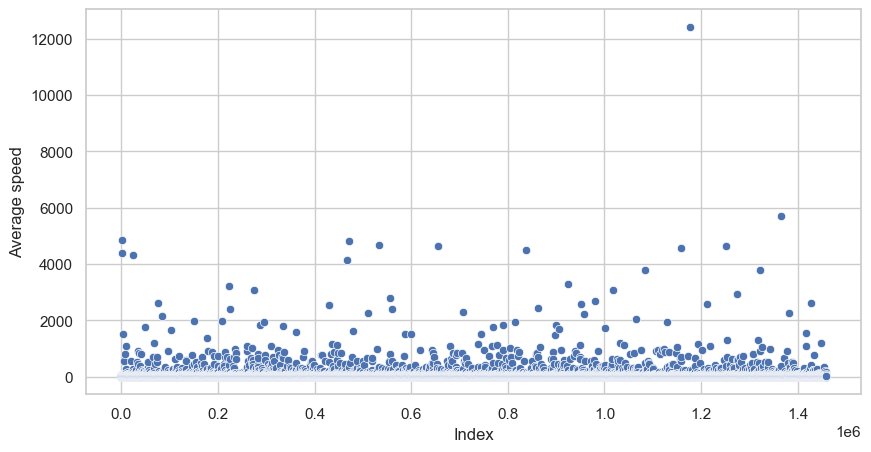

In [276]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

It is from here that we see that we have “teleportation trips”, for which the average speed is more than 1000 km/h. There is even one whose average speed was more than 12,000 km/h!

Let's agree that the maximum average speed that taxi drivers can reach will be 300 km/h.

_____
We will find trips whose duration exceeds 24 hours. And remove them from the data set.

Let's find trips whose average speed along the shortest route exceeds 300 km/h and remove them from the data.

In [277]:
mask_1 = taxi_data['trip_duration'] > 24*3600
taxi_data.drop(index=taxi_data[mask_1].index, inplace=True)
print('Removed based on time of trip', mask_1.sum())

mask_2 = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 > 300
taxi_data.drop(index=taxi_data[mask_2].index, inplace=True)
print('Removed based on speed', mask_2.sum())

Removed based on time of trip 4
Removed based on speed 407


## 3. Exploratory data analysis

* We examine the generated data set;
* Let's try to find patterns that allow us to formulate preliminary hypotheses regarding what factors are decisive in determining the duration of the trip;
* Let's supplement our analysis with visualizations illustrating; study.

The main metric for the quality of the solution to the problem will be RMSLE - Root Mean Squared Log Error, which is calculated based on the target variable on a logarithmic scale. In this case, it is advisable to immediately logarithm the trip duration attribute and consider the logarithm as a target attribute in the analysis:
$$trip\_duration\_log = log(trip\_duration+1),$$
where the symbol log stands for natural logarithm.

In [278]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

____
Let's build a histogram and boxplot of trip durations on a logarithmic scale (trip_duration_log).
Based on the visualization, let’s make a guess: is the resulting distribution normal?
Let’s test our hypothesis using the D’Agostino test at a significance level of $\alpha=0.05$.

a) What is the calculated p-value?
b) Is the distribution of travel times on a logarithmic scale normal?

Text(0.5, 1.0, 'Distribution of the target attribute of trip duration on a logarithmic scale')

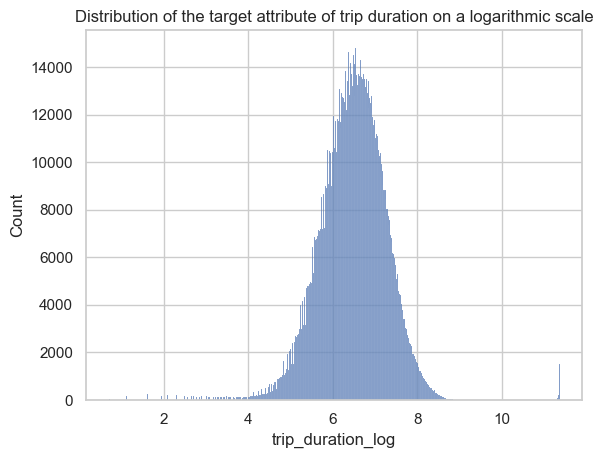

In [279]:
sns.histplot(taxi_data['trip_duration_log'])
plt.title('Distribution of the target attribute of trip duration on a logarithmic scale')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Distribution of the target attribute of trip duration on a logarithmic scale')

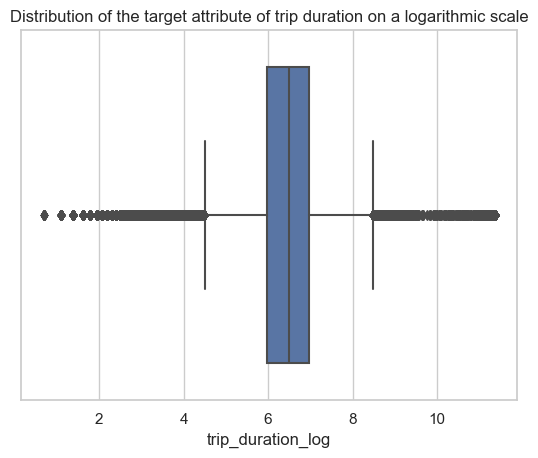

In [280]:
sns.boxplot(taxi_data['trip_duration_log'])
plt.title('Distribution of the target attribute of trip duration on a logarithmic scale')

In [281]:
from scipy.stats import normaltest
_, p = normaltest(taxi_data['trip_duration_log'])
#normaltest returns two-sided probability for hypothesis testing
print('p=%.5f' % p)

# Interpretation
H0 = 'The data is normally distributed'
Ha = 'The data is not normally distributed (we reject H0)'
if p > 0.05/2:
    print(H0)
else:
    print(Ha)

p=0.00000
The data is not normally distributed (we reject H0)


Let's build a visualization that will allow us to compare the distribution of trip duration on a logarithmic scale (trip_duration_log) depending on the taxi fleet (vendor_id).

Let's compare the two distributions with each other.

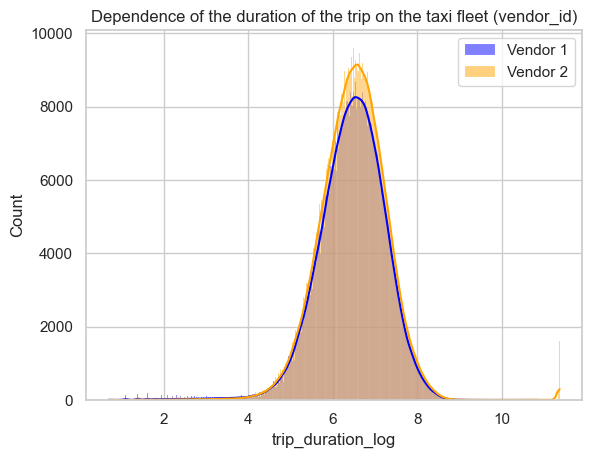

In [282]:
# Filtering data for each vendor_id value
vendor_1_data = taxi_data[taxi_data['vendor_id'] == 1]
vendor_2_data = taxi_data[taxi_data['vendor_id'] == 2]

# Creating a histogram for vendor_id = 1
sns.histplot(x='trip_duration_log', data=vendor_1_data, kde=True, label='Vendor 1', color='blue')

# Creating a histogram for vendor_id = 2
sns.histplot(x='trip_duration_log', data=vendor_2_data, kde=True, label='Vendor 2', color='orange')

# Adding a Legend
plt.legend()
plt.title('Dependence of the duration of the trip on the taxi fleet (vendor_id)')
# Show graph
plt.show()

__The data shows that the choice of taxi fleet does not depend on the duration of the trip (on a logarithmic scale)__

____
Let's build a visualization that will allow us to compare the distribution of trip duration on a logarithmic scale (trip_duration_log) depending on the sign of sending a message to the supplier (store_and_fwd_flag).

Let's compare the two distributions with each other.

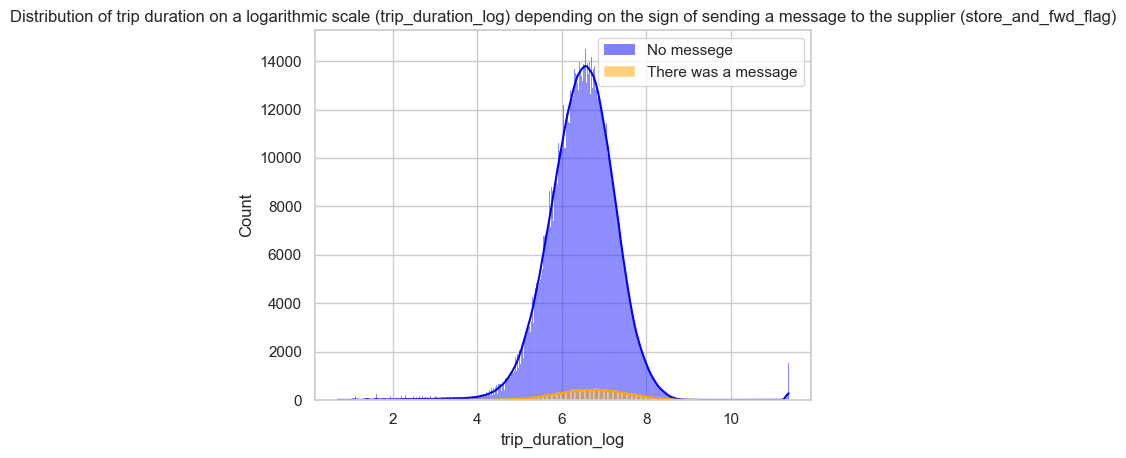

In [283]:
# Filtering data for each value
no_messege = taxi_data[taxi_data['store_and_fwd_flag'] == 'N']
yes_massega = taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']

sns.histplot(x='trip_duration_log', data=no_messege, kde=True, label='No messege', color='blue')


sns.histplot(x='trip_duration_log', data=yes_massega, kde=True, label='There was a message', color='orange')

# Adding a Legend
plt.legend()

plt.title('Distribution of trip duration on a logarithmic scale (trip_duration_log) depending on the sign of sending a message to the supplier (store_and_fwd_flag)')

# Show graph
plt.show()

The data contains such a sign as sending a message to the supplier (store_and_fwd_flag). Significantly different from this attribute is the trip duration attribute (on a logarithmic scale)

___
Let's build two visualizations:
* Distribution of the number of trips depending on the hour of the day;
* Dependence of the median trip duration on the hour of the day.

Based on the constructed graphs, let us pay attention to the following questions:

a) At what time of day are taxis ordered least often?

b) At what time of day does the median trip duration peak?

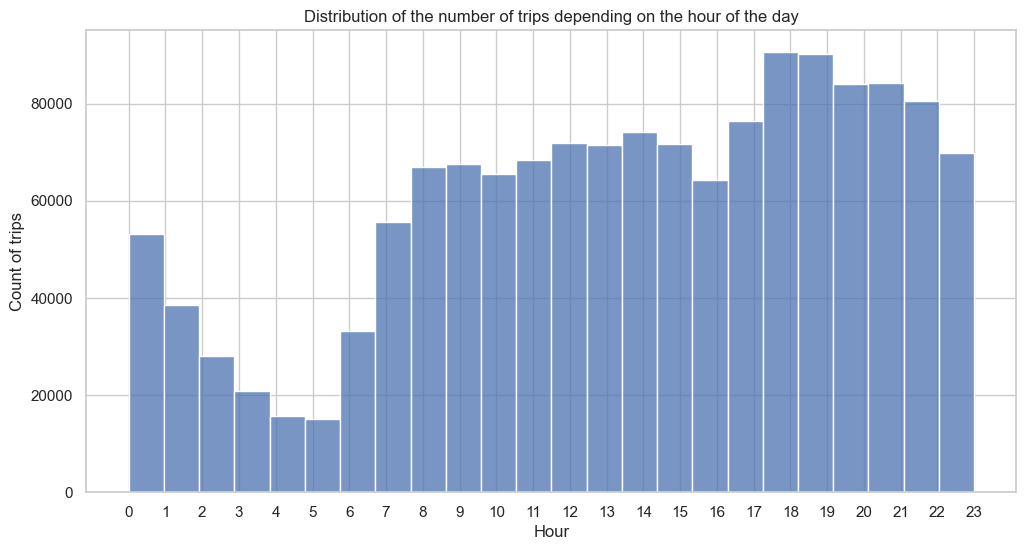

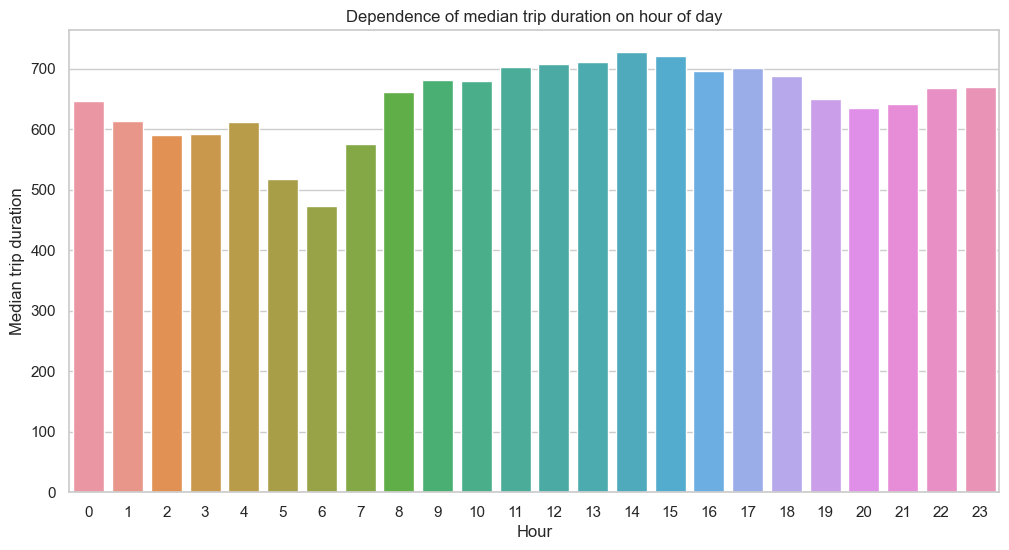

In [284]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Visualization 1: Distribution of the number of trips depending on the hour of the day
plt.figure(figsize=(12, 6))
sns.histplot(taxi_data['pickup_hour'], bins=24, kde=False)
plt.title('Distribution of the number of trips depending on the hour of the day')
plt.xlabel('Hour')
plt.ylabel('Count of trips')
plt.xticks(range(24))
plt.show()

# Visualization 2: Dependence of median trip duration on hour of day
plt.figure(figsize=(12, 6))
sns.barplot(
    x='pickup_hour', y='trip_duration',
    data=taxi_data.groupby('pickup_hour')['trip_duration'].median().reset_index()
)
plt.title('Dependence of median trip duration on hour of day')
plt.xlabel('Hour')
plt.ylabel('Median trip duration')
plt.xticks(range(24))
plt.show()

__The peak minimum orders are 4 and 5 pm.
Peak maximum number of orders at 18 and 29 hours__

___
Let's build two visualizations:
* Distribution of the number of trips depending on the day of the week;
* Dependence of the median trip duration on the day of the week.

Based on the constructed graphs, we will answer the following questions:
a) On what day of the week are the most trips made?
b) On what day of the week is the median travel time the shortest?

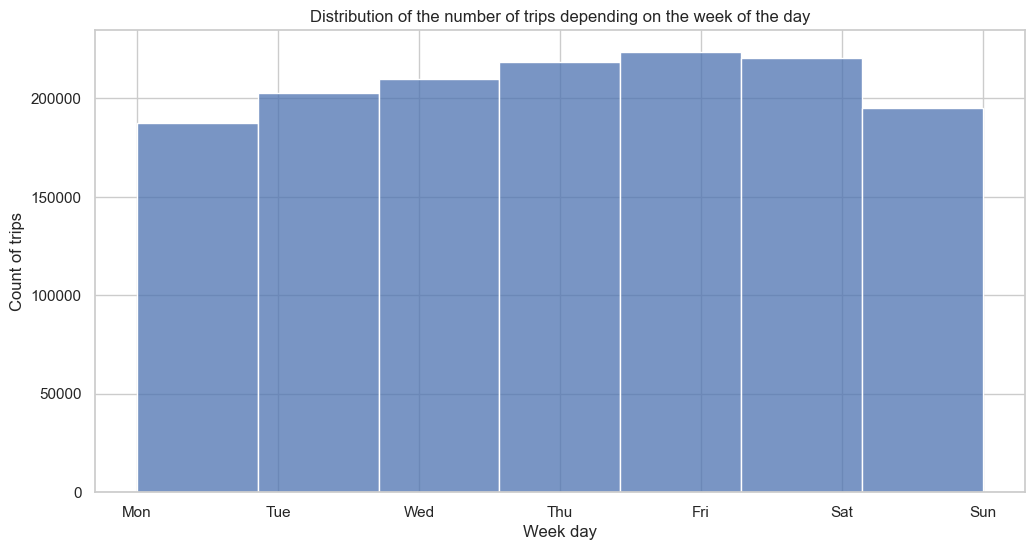

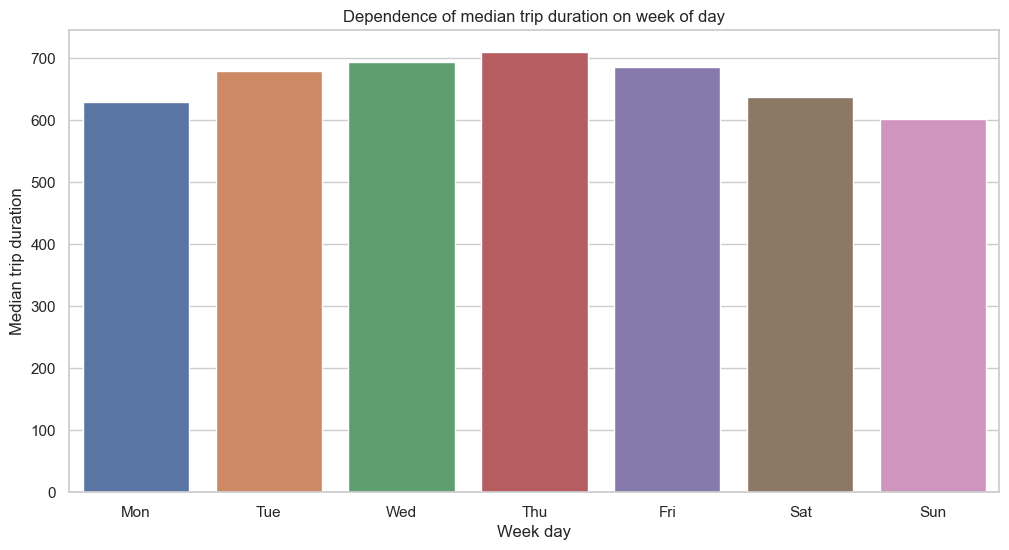

In [285]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Distribution of the number of trips depending on the week of the day
plt.figure(figsize=(12, 6))
sns.histplot(taxi_data['pickup_day_of_week'], bins=7, kde=False)
plt.title('Distribution of the number of trips depending on the week of the day')
plt.xlabel('Week day')
plt.ylabel('Count of trips')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Dependence of median trip duration on week of day
plt.figure(figsize=(12, 6))
sns.barplot(
    x='pickup_day_of_week', y='trip_duration',
    data=taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().reset_index()
)
plt.title('Dependence of median trip duration on week of day')
plt.xlabel('Week day')
plt.ylabel('Median trip duration')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

___
Let's look at both time characteristics at the same time.

Let's build a pivot table in which the rows show the hours (pickup_hour), the columns show the days of the week (pickup_day_of_week), and the cells show the median trip duration (trip_duration).

We visualize the resulting summary table using a heat map (recommended palette - coolwarm).

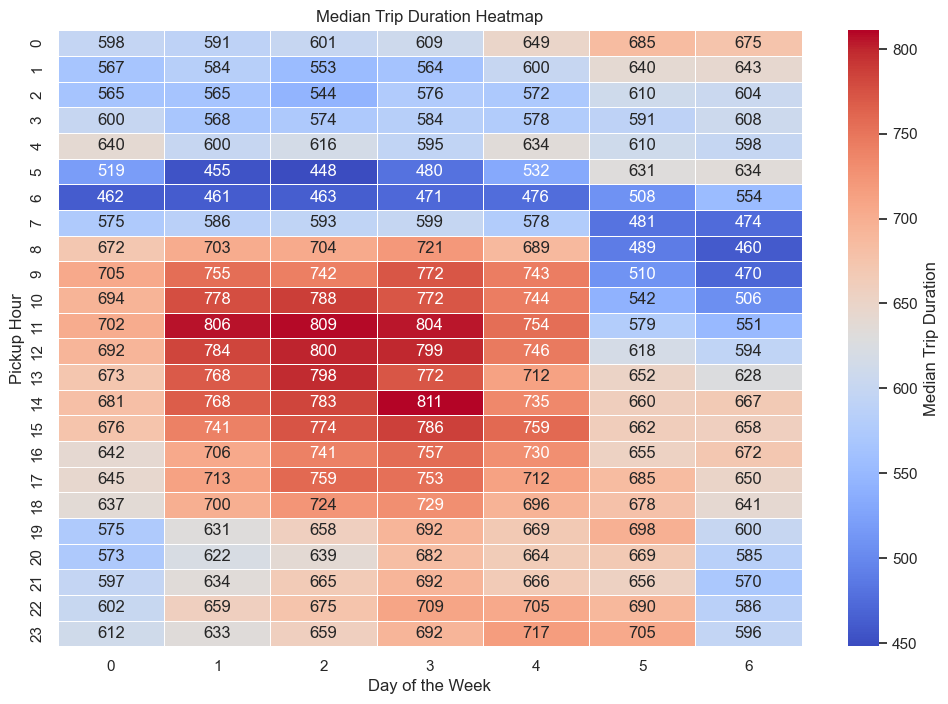

In [286]:
# Create a pivot table
pivot_table = pd.pivot_table(taxi_data, values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc=np.median)
# Build a heat map
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Median Trip Duration'})
plt.title('Median Trip Duration Heatmap')
plt.xlabel('Day of the Week')
plt.ylabel('Pickup Hour')
plt.show()

__The longest trips (in median terms) are observed from Monday to Friday between 8 am and 6 pm.
The longest median trip duration was observed on Thursday at 2 p.m.__

___
Let's build two scatter diagrams:
* the first illustrates the geographical location of travel starting points (pickup_longitude, pickup_latitude)
* second location of trip completion points (dropoff_longitude, dropoff_latitude).

To do this, on the diagrams we plot latitude (longitude) along the abscissa axis, and longitude (latitude) along the ordinate axis.
We will include in the visualization only those points that are located within New York - we will add the following restrictions on the boundaries of the abscissa and ordinate axes:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Let's add coloring to the diagrams based on the ten geographic clusters (geo_cluster) that we generated earlier.

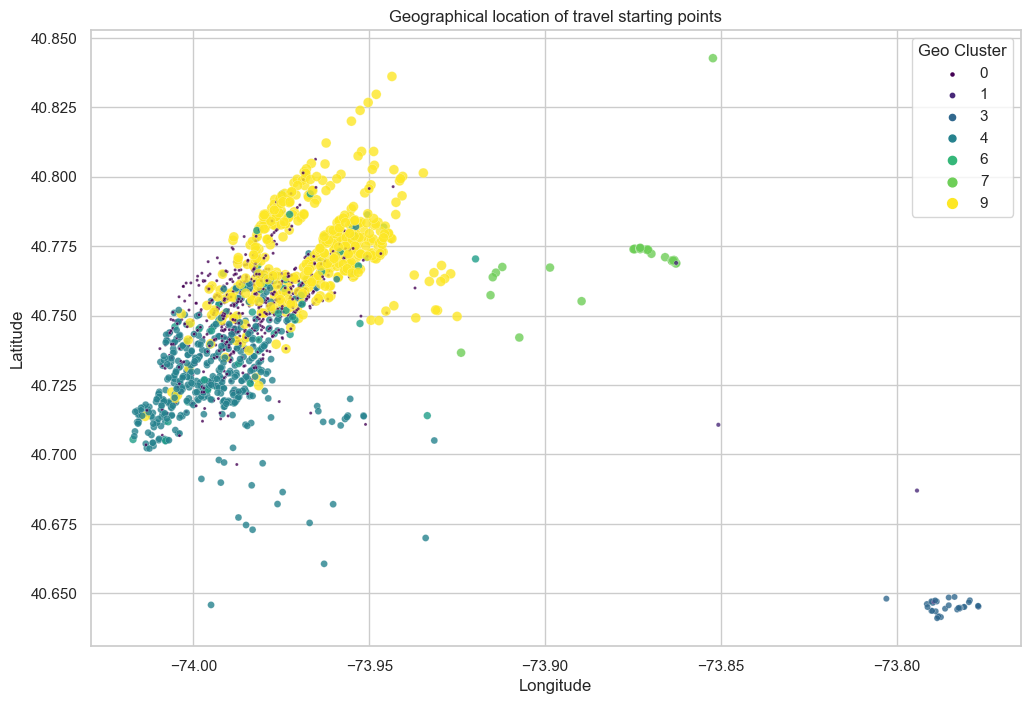

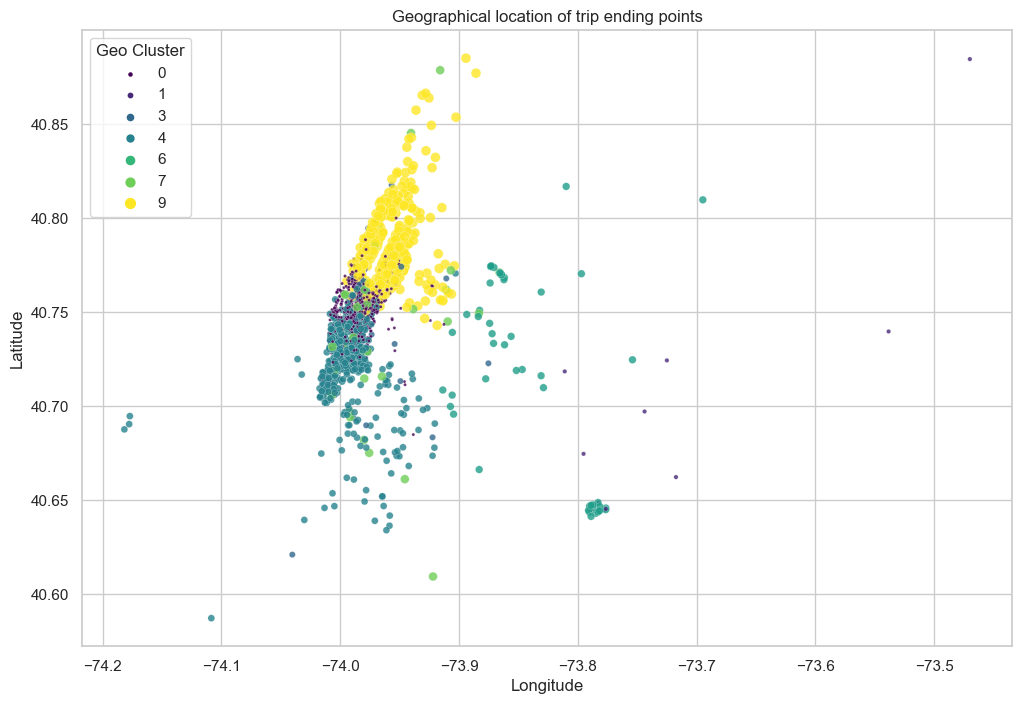

In [287]:
# New York Border Restrictions
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# We select only those points that are within New York
filtered_data = taxi_data[
    (taxi_data['pickup_longitude'] >= city_long_border[0]) & (taxi_data['pickup_longitude'] <= city_long_border[1]) &
    (taxi_data['pickup_latitude'] >= city_lat_border[0]) & (taxi_data['pickup_latitude'] <= city_lat_border[1])
]

# Building a Scatterplot to Start Trips
plt.figure(figsize=(12, 8))
scatter_start = sns.scatterplot(
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    data=filtered_data.sample(n=2000),
    palette='viridis',
    alpha=0.8,
    size='geo_cluster',
    sizes=(5, 50),
)
plt.title('Geographical location of travel starting points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Geo Cluster')
plt.show()

# Scatterplot plotting for trip completions
plt.figure(figsize=(12, 8))
scatter_end = sns.scatterplot(
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    data=filtered_data.sample(n=2000),
    palette='viridis',
    alpha=0.8,
    size='geo_cluster',
    sizes=(5, 50),
)
plt.title('Geographical location of trip ending points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Geo Cluster')
plt.show()

__2 clusters (out of ten) were not included in the diagrams (located outside New York)__

## 4. Feature engineering

Before moving on to building the model, there are a few more steps left to do.
* Many machine learning algorithms cannot process categorical features in their usual form. So we need to encode them;
* We need to select the features that we will use to train the model;
* It is necessary to scale and transform some features in order to improve the convergence of models based on numerical methods.

In [289]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


For ease of use, let's make a copy of the original table with trips:

In [290]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


___
Let’s immediately take care of the obvious uninformative and redundant signs.
The 'id', 'dropoff_datetime' signs do not provide us with useful information or contribute to a possible data leak

In [291]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)

Previously, we extracted all the information we needed from the start date of the trip, now we can get rid of these signs, since we will no longer need them:

In [292]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


____
Let's encode the vendor_id attribute in the train_data table so that it is equal to 0 if the taxi fleet identifier is 1, and 1 otherwise.

Let's encode the store_and_fwd_flag attribute in the train_data table so that it is equal to 0 if the flag is set to 'N', and 1 otherwise.


In [293]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

_____
Let's create the data_onehot table from the one-hot encoded characteristics pickup_day_of_week, geo_cluster and events in the train_data table using OneHotEncoder from the sklearn library. Set the drop parameter to 'first' to remove the first binary column, thereby not creating unnecessary features.

As a result of the work of OneHotEncoder, we will get an unnamed numpy array, which we will need to convert back to a DataFrame for more convenient work in the future. To get the names of encoded columns, an object of type OneHotEncoder has a special method get_feature_names_out(). It returns a list of new encoded column names in the format <original column name>_<category name>.

Usage example:
``` python
# Getting the encoded column names
column_names = one_hot_encoder.get_feature_names_out()
# We compose a DataFrame from encoded features
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

In this pseudocode:
* one_hot_encoder - object of the OneHotEncoder class
* data_onehot - numpy array obtained as a result of transformation by the encoder

As a result, a DataFrame `data_onehot` should be formed, which contains the encoded categorical attributes pickup_day_of_week, geo_cluster and events.

In [294]:
encoder = preprocessing.OneHotEncoder(drop='first') 
data_onehot = encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
# Get the encoded column names
column_names = encoder.get_feature_names_out()
# We compose a DataFrame from encoded features
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data_onehot

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458228,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458229,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1458230,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Let's add the resulting table with encoded characteristics:

In [295]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


___
Now that the categorical features have been preprocessed, we will form a matrix of observations X, a vector of the target variable y and its logarithm y_log. The observation matrix will include all columns from the table with trips with the exception of the target attribute trip_duration and its logarithmic version trip_duration_log:

In [296]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

__We will train all our models on the logarithmic version of y_log.__

The selected validation type is hold-out. Let's split the sample into training and validation in a ratio of 67/33:

In [297]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

At the moment we have quite a lot of signs: most likely, not all of them will be important. Let's leave only those that are most strongly related to the target variable and will definitely contribute to improving the quality of the model.

_____
Using SelectKBest, we will select 25 features that are best suited for predicting the target variable on a logarithmic scale. We implement the selection using the training sample using the parameter score_func = f_regression.

We indicate the characteristics that were included in the list of selected

In [298]:
from sklearn.feature_selection import SelectKBest, f_regression

# Creating a SelectKBest object with score_func=f_regression and k=25
best_features_selector = SelectKBest(score_func=f_regression, k=25)

# Training SelectKBest on training data
X_train_selected = best_features_selector.fit_transform(X_train, y_train_log)

# Output of selected features
selected_feature_indices = best_features_selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
print(selected_features)

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
       'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7',
       'geo_cluster_9'],
      dtype='object')


In [299]:
X_train = X_train_selected
X_valid = X_valid[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
       'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7',
       'geo_cluster_9']]

____
Since we will use various models, including those that contain numerical optimization methods, let’s take care of scaling factors in advance.

We normalize the predictors in the training and validation sets using MinMaxScaler from the sklearn library. The normalizer is trained on the training set, and the transformation is performed on the training and validation samples.

Let's calculate the arithmetic mean for the first predictor (i.e., for the first column of the matrix) from the validation sample.

In [300]:
# initialize the MinMaxScaler normalizer
mm_scaler = preprocessing.MinMaxScaler()

# encode
X_train_scaled = mm_scaler.fit_transform(X_train)
X_valid_scaled = mm_scaler.transform(X_valid)

print(X_valid_scaled[:, 0].mean())

0.5354341180797852


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



## 5. Solving the regression problem: linear regression and decision trees

Let's define a metric by which we will measure the quality of our models. We will follow the rules of the original Kaggle competition and use RMSLE (Root Mean Squared Log Error) as a metric, which is calculated as:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
where:
* $y_i$ - true duration of the i-th taxi trip (trip_duration)
* $\hat{y_i}$ - duration of the i-th taxi trip predicted by the model
Note that we have already carried out the logarithm of the target feature in advance, so it will be enough for us to calculate the RMSE metric for a model trained to predict the duration of a taxi trip on a logarithmic scale:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 

Let's build a linear regression model on the training set (the factors must be normalized, the target variable must be used on a logarithmic scale).

For the resulting model, we calculate the RMSLE metric on the training and validation samples.

In [301]:
model = linear_model.LinearRegression()
model.fit(X_train_scaled, y_train_log)

# Prediction on the training set
y_train_pred_log = model.predict(X_train_scaled)

# Forecast on the validation set
y_valid_pred_log = model.predict(X_valid_scaled)

# Calculation of the RMSLE metric on training and validation sets
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Output of RMSLE metric rounded to hundredths
print(f"RMSLE на тренировочной выборке: {rmsle_train.round(2)}")
print(f"RMSLE на валидационной выборке: {rmsle_valid:.2f}")

RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


___
Let's generate 2nd degree polynomial features using PolynomialFeatures from the sklearn library. Set the include_bias parameter to False.

Let's build a 2nd degree polynomial regression model on the training sample (factors must be normalized, we use the target variable on a logarithmic scale).

a) For the resulting model, we calculate the RMSLE metric on the training and validation samples. Round your answer to the nearest hundredth.

b) Does this model show signs of overfitting?

In [302]:
# Create an object to generate polynomial features of degree 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# We calculate the generation parameters - the resulting number of features
poly.fit(X_train_scaled)
# We carry out the transformation for each of the samples
X_train_scaled_poly = poly.transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)

model_poly = linear_model.LinearRegression()
model_poly.fit(X_train_scaled_poly, y_train_log)

# Prediction on the training set
y_train_pred_log_poly = model_poly.predict(X_train_scaled_poly)

# Forecast on the validation set
y_valid_pred_log_poly = model_poly.predict(X_valid_scaled_poly)

# Calculation of the RMSLE metric on training and validation sets
rmsle_train_poly = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_poly))
rmsle_valid_poly = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_poly))
# Output of RMSLE metric rounded to hundredths
print(f"RMSLE on the training set: {rmsle_train_poly.round(2)}")
print(f"RMSLE on the validation set: {rmsle_valid_poly:.2f}")

RMSLE on the training set: 0.47
RMSLE on the validation set: 0.70


The metric on the validation set is significantly worse than on the training set - obvious overfitting

___
Let's build a 2nd degree polynomial regression model with L2-regularization (Tikhonov regularization) on the training set (factors must be normalized, we use the target variable on a logarithmic scale). We will set the regularization coefficient $\alpha$ equal to 1, and leave the remaining parameters at default.

For the resulting model, we calculate the RMSLE metric on the training and validation samples. The answer has been rounded to the nearest hundredth.

In [303]:
model_ridge = linear_model.Ridge(alpha=1)
model_ridge.fit(X_train_scaled_poly, y_train_log)

# Prediction on the training set
y_train_pred_log_poly_ridge = model_ridge.predict(X_train_scaled_poly)

# Forecast on the validation set
y_valid_pred_log_poly_ridge = model_ridge.predict(X_valid_scaled_poly)

# Calculation of the RMSLE metric on training and validation sets
rmsle_train_poly_ridge = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_poly_ridge))
rmsle_valid_poly_ridge = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_poly_ridge))
# Output of RMSLE metric rounded to hundredths
print(f"RMSLE on training set: {rmsle_train_poly_ridge.round(2)}")
print(f"RMSLE on validation set: {rmsle_valid_poly_ridge:.2f}")

RMSLE on training set: 0.48
RMSLE on validation set: 0.48


Great, the metrics are much better, the regularization worked well

___
Let's build a decision tree model (DecisionTreeRegressor) on the training sample (factors must be normalized, we use the target variable on a logarithmic scale). Let's leave all parameters as default.

a) For the resulting model, we calculate the RMSLE metric on the training and validation samples.

b) Does the model show signs of overfitting?

In [304]:
tree_model = tree.DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train_log)

# Prediction on the training set
y_train_pred_log_tree = tree_model.predict(X_train_scaled)

# Forecast on the validation set
y_valid_pred_log_tree = tree_model.predict(X_valid_scaled)

# Calculation of the RMSLE metric on training and validation sets
rmsle_train_tree = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_tree))
rmsle_valid_tree = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_tree))

# Output of RMSLE metric rounded to hundredths
print(f"RMSLE on training set: {rmsle_train_tree.round(2)}")
print(f"RMSLE on validation set: {rmsle_valid_tree:.2f}")


RMSLE on training set: 0.0
RMSLE on validation set: 0.57


Our decision tree didn't work well, overfitting

___
Let's go through all possible options for the depth of the decision tree in the range from 7 to 20:

max_depths = range(7, 20)

Parameter random_state = 42.

Let's construct linear graphs of changes in the RMSE metric on the training and validation samples depending on the value of the decision tree depth parameter.

a) Let’s find the optimal value of the maximum tree depth for which the minimum RMSLE value will be observed on the training set, but overfitting will not yet be observed (the validation curve does not yet begin to increase).

b) Let us determine the value of the RMSLE metrics on the training and validation samples for the decision tree with the selected optimal depth.

In [305]:
def max_depths_selection(X, y, X_v, y_v):
    rmsle_train_selection = {}
    rmsle_valid_selection = {}
    for i in range(7, 20):
        tree_model = tree.DecisionTreeRegressor(random_state=42, max_depth=i)
        tree_model.fit(X, y)
        # Прогноз на тренировочной выборке
        y_train_pred_log_tree2 = tree_model.predict(X)
        # Прогноз на валидационной выборке
        y_valid_pred_log_tree2 = tree_model.predict(X_v)
        # Вычисление метрики RMSLE на тренировочной и валидационной выборках
        rmsle_train_selection[i] = np.sqrt(metrics.mean_squared_error(y, y_train_pred_log_tree2))
        rmsle_valid_selection[i] = np.sqrt(metrics.mean_squared_error(y_v, y_valid_pred_log_tree2))
    return rmsle_train_selection, rmsle_valid_selection

rmsle_train_selection, rmsle_valid_selection = max_depths_selection(X_train_scaled, y_train_log, X_valid_scaled, y_valid_log)

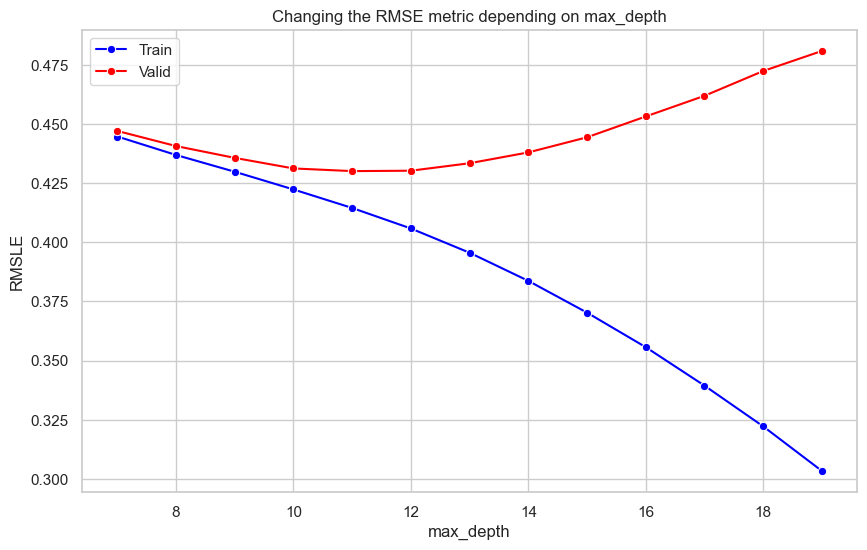

In [306]:
# Creating a subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Retrieving max_depth and RMSLE values from dictionaries
depths_train, rmsle_train = zip(*rmsle_train_selection.items())
depths_valid, rmsle_valid = zip(*rmsle_valid_selection.items())

# Plotting the training set (blue line)
sns.lineplot(x=depths_train, y=rmsle_train, label='Train', color='blue', marker='o')

# Plotting the validation set (red line)
sns.lineplot(x=depths_valid, y=rmsle_valid, label='Valid', color='red', marker='o')

# Display settings
ax.set_title('Changing the RMSE metric depending on max_depth')
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSLE')
ax.grid(True)
ax.legend()

# Graph display
plt.show()

We see the optimal response of the model at a depth of 12. Let’s build a decision tree with a depth of 12.

In [307]:
tree_model_try = tree.DecisionTreeRegressor(random_state=42, max_depth=12)
tree_model_try.fit(X_train_scaled, y_train_log)
# Prediction on the training set
y_train_pred_log_tree_try = tree_model_try.predict(X_train_scaled)
# Forecast on the validation set
y_valid_pred_log_tree_try = tree_model_try.predict(X_valid_scaled)
# Calculation of the RMSLE metric on training and validation sets
print('RMSLE train', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_tree_try)), 2))
print('RMSLE valid', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_tree_try)), 2))

RMSLE train 0.41
RMSLE valid 0.43


The same thing only with a maximum depth of 11

In [308]:
tree_model_try = tree.DecisionTreeRegressor(random_state=42, max_depth=11)
tree_model_try.fit(X_train_scaled, y_train_log)
# Prediction on the training set
y_train_pred_log_tree_try = tree_model_try.predict(X_train_scaled)
# Forecast on the validation set
y_valid_pred_log_tree_try = tree_model_try.predict(X_valid_scaled)
# Calculation of the RMSLE metric on training and validation sets
print('RMSLE train', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_tree_try)), 2))
print('RMSLE valid', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_tree_try)), 2))

RMSLE train 0.41
RMSLE valid 0.43


## 6. Solving the regression problem: ensemble methods and forecasting

Let's build a random forest model on the training set (factors must be normalized, use the target variable on a logarithmic scale). As hyperparameters:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

For the resulting model, we calculate the RMSLE metric on the training and validation samples.

In [309]:
random_forest_base = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_leaf=20,
    random_state=42
)
random_forest_base.fit(X_train_scaled, y_train_log)
y_train_pred_rf = random_forest_base.predict(X_train_scaled)
y_valid_pred_rf = random_forest_base.predict(X_valid_scaled)
# Calculation of the RMSLE metric on training and validation sets
print('RMSLE train', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_rf)), 2))
print('RMSLE valid', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_rf)), 2))

RMSLE train 0.4
RMSLE valid 0.41


Metrics just got better

___
Let's build a model of gradient boosting over decision trees (GradientBoostingRegressor) on the training sample (factors must be normalized, we use the target variable on a logarithmic scale). As hyperparameters:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

For the resulting model, we calculate the RMSLE metric on the training and validation samples.

In [310]:
gradient_boost_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5, 
    n_estimators=100, 
    max_depth=6, 
    min_samples_split=30, 
    random_state=42,
    verbose=True    
)
gradient_boost_model.fit(X_train_scaled, y_train_log)
y_train_pred_grad_boost = gradient_boost_model.predict(X_train_scaled)
y_valid_pred_grad_boost = gradient_boost_model.predict(X_valid_scaled)
# Calculation of the RMSLE metric on training and validation sets
print('RMSLE train', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_grad_boost)), 2))
print('RMSLE valid', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_grad_boost)), 2))

      Iter       Train Loss   Remaining Time 
         1           0.3110           13.44m
         2           0.2247           13.65m
         3           0.1987           13.62m
         4           0.1876           13.31m
         5           0.1823           13.66m
         6           0.1783           13.90m
         7           0.1756          810.99m
         8           0.1730          704.28m
         9           0.1709          620.61m
        10           0.1696         1932.91m
        20           0.1577          866.72m
        30           0.1538          509.35m
        40           0.1502          329.79m
        50           0.1480          221.41m
        60           0.1451          148.68m
        70           0.1431           96.20m
        80           0.1410           56.47m
        90           0.1393           25.26m
       100           0.1383            0.00s
RMSLE train 0.37
RMSLE valid 0.39


The metric has improved, the best option

____
Let's build a bar graph of the significance coefficients for each factor.


In [311]:
importances_gb = gradient_boost_model.feature_importances_

# Creating a DataFrame
imp = pd.DataFrame({'Importance': importances_gb}, index=selected_features)

# Sort by importance
imp = imp.sort_values(by='Importance', ascending=False)

# Output DataFrame
print(imp)

                      Importance
total_distance          0.628963
total_travel_time       0.187075
pickup_hour             0.059600
dropoff_latitude        0.029514
haversine_distance      0.025467
dropoff_longitude       0.013533
pickup_latitude         0.010963
pickup_longitude        0.010642
pickup_day_of_week_6    0.007516
pickup_day_of_week_5    0.005420
number_of_steps         0.005419
temperature             0.004456
vendor_id               0.004043
pickup_day_of_week_4    0.001319
pickup_holiday          0.001120
pickup_day_of_week_3    0.001052
pickup_day_of_week_2    0.000989
passenger_count         0.000757
pickup_day_of_week_1    0.000735
geo_cluster_1           0.000584
geo_cluster_9           0.000520
geo_cluster_5           0.000121
geo_cluster_7           0.000119
store_and_fwd_flag      0.000044
geo_cluster_3           0.000028


___
For the best of the constructed models, we calculate the median absolute error (MeAE - in sklearn function median_absolute_error) of predicting the duration of a taxi trip on the validation set:
$$ MeAE = median(|y_i-\hat{y_i}|)$$
Let's convert the MeAE metric value into minutes and round it to tenths.

In [312]:
print('MAE train:', round(metrics.median_absolute_error(np.exp(y_train_log) - 1, np.exp(y_train_pred_grad_boost) - 1) / 60, 1))
print('MAE valid:', round(metrics.median_absolute_error(np.exp(y_valid_log) - 1, np.exp(y_valid_pred_grad_boost) - 1) / 60, 1))

MAE train: 1.8
MAE valid: 1.8


Let's make a submit prediction for the deferred test data set.

Let's read the test data and pre-select the column with trip identifiers from the test data set. We will still need it:

In [313]:
test_data = pd.read_csv("test.csv")
osrm_data_test = pd.read_csv("osrm_data_test.csv")
test_id = test_data['id']

Before creating a forecast for the test sample, it is necessary to perform all the manipulations with the data that we performed with the training sample, namely:
* Convert the pickup_datetime attribute to datetime format;
* Add new features (temporal, geographic, weather and other factors);
* Clear data from gaps;
* Encode categorical features:
     * Encode binary features;
     * Encode nominal features using OneHotEncoder trained on the training set;
* Generate a matrix of observations, leaving in the table only those characteristics that were selected using SelectKBest;
* Normalize data using MinMaxScaler trained on the training set.

In [314]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)
 
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selected_features]
X_test_scaled = mm_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_29826/1276341313.py:8: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



Shape of data: (625134, 25)


Only after completing all these steps can a prediction be made about the trip duration for the test sample. Let's not forget to convert the predictions from a logarithmic scale to a true scale using the formula:
$$y_i=exp(z_i)-1$$

After we generate a prediction of the duration of trips on the test sample, it will be necessary to create a submission file in csv format

In [315]:
y_test_predict = np.exp(gradient_boost_model.predict(X_test_scaled)) - 1

In [316]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

_______
Let's try to improve our prediction using the extreme gradient boosting model (XGBoost) from the xgboost library.

**XGBoost** is a modern machine learning model that is a continuation of Friedman’s idea of gradient boosting. It has several advantages over the classic gradient boosting model from the sklearn library: increased performance due to parallelization of the training process, improved solution quality due to improved boosting algorithm, less tendency to overfit, and wider functionality for managing model parameters.

In [317]:
!pip install xgboost # To use it, you must first install the xgboost package:

In [318]:
import xgboost as xgb # import the module

Before training the model, you need to convert the data sets to the xgboost.DMatrix data type:

In [319]:
selected_features = list(selected_features)
# Creating observation matrices in DMatrix format
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=selected_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=selected_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_features)

The XGBoost model is trained using the train method, to which it is necessary to pass the model parameters, the data set, the number of base models in the ensemble, as well as additional parameters:

In [320]:
# Model hyperparameters
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Training and validation set
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Training the XGBoost model
model = xgb.train(
    params=xgb_pars, # model hyperparameters
    dtrain=dtrain, # training set
    num_boost_round=300, # number of models in the ensemble
    evals=watchlist, # samples on which the matrix is calculated
    early_stopping_rounds=20, # early stop
    maximize=False, # changing the search for maximum to minimum
    verbose_eval=10 # step through which metrics are displayed
)

[0]	train-rmse:0.74154	valid-rmse:0.74355
[10]	train-rmse:0.49217	valid-rmse:0.49478
[20]	train-rmse:0.44036	valid-rmse:0.44325
[30]	train-rmse:0.42603	valid-rmse:0.42916
[40]	train-rmse:0.41877	valid-rmse:0.42209
[50]	train-rmse:0.41374	valid-rmse:0.41732
[60]	train-rmse:0.40933	valid-rmse:0.41321
[70]	train-rmse:0.40677	valid-rmse:0.41095
[80]	train-rmse:0.40424	valid-rmse:0.40872
[90]	train-rmse:0.40212	valid-rmse:0.40686
[100]	train-rmse:0.40056	valid-rmse:0.40563
[110]	train-rmse:0.39892	valid-rmse:0.40429
[120]	train-rmse:0.39768	valid-rmse:0.40333
[130]	train-rmse:0.39662	valid-rmse:0.40250
[140]	train-rmse:0.39551	valid-rmse:0.40166
[150]	train-rmse:0.39405	valid-rmse:0.40045
[160]	train-rmse:0.39289	valid-rmse:0.39950
[170]	train-rmse:0.39193	valid-rmse:0.39885
[180]	train-rmse:0.39115	valid-rmse:0.39839
[190]	train-rmse:0.39051	valid-rmse:0.39808
[200]	train-rmse:0.38984	valid-rmse:0.39773
[210]	train-rmse:0.38918	valid-rmse:0.39731
[220]	train-rmse:0.38839	valid-rmse:0.39686

You can predict the target feature on new data using the predict() method:

In [321]:
#Making a prediction on a test data set
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39427


Just like all models based on decision trees as base models, XGBoost has the ability to determine factor importance coefficients. Moreover, the library has a built-in ability to visualize the importance of factors in the form of a bar chart. The plot_importance() function is responsible for this feature:

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

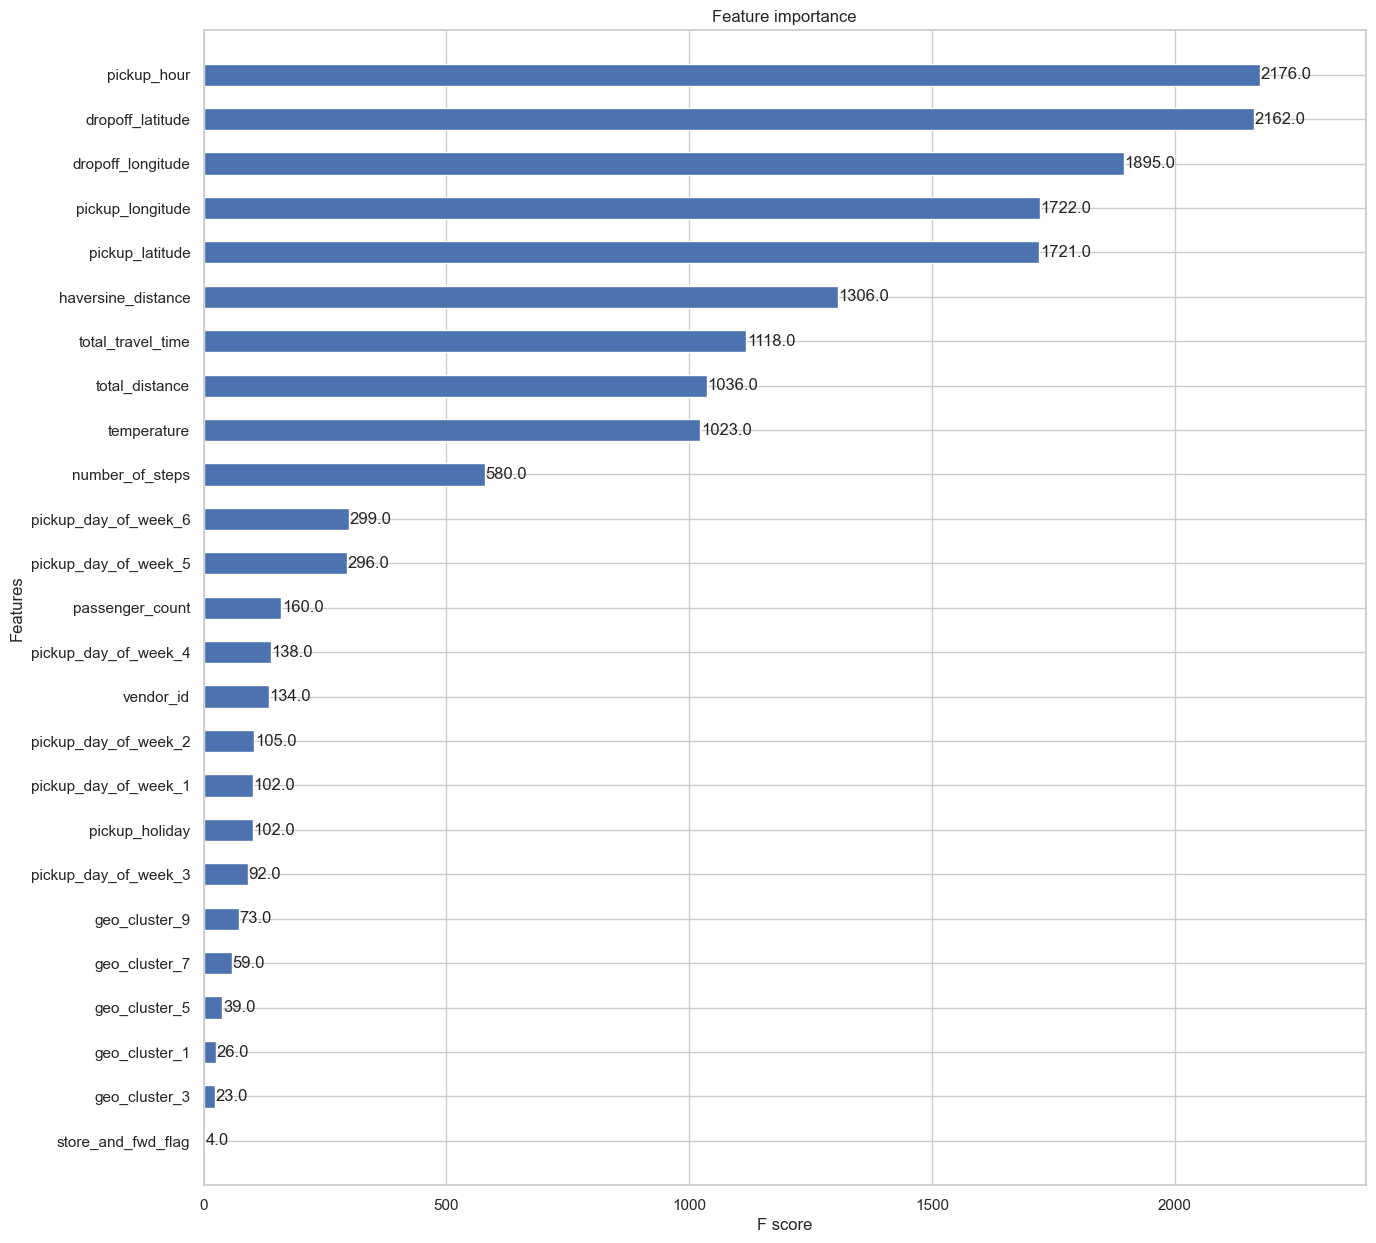

In [322]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

Having experimented with the models, in practice we see that the gradient boosting model showed the best metrics

In [324]:
# Let's fix the version of the packages so that the experiments are reproducible:
!pip freeze > requirements.txt